In [1]:
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import time
import diffusion_pde as dpde
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
import wandb
from omegaconf import OmegaConf
from pathlib import Path
from skopt import gp_minimize

In [8]:
root_path = dpde.utils.get_repo_root()
cfg_rel_path = "logs/hydra/2025-11-04_15-58-37_heat-final-log/.hydra/config.yaml" # log timing
config_path = root_path / cfg_rel_path
cfg = OmegaConf.load(config_path)

res = dpde.utils.ResultsObject(cfg_path=config_path)

model_path = res.model_path
data_path = res.data_path
test_path = Path("/home/s204790/dynamical-pde-diffusion/data/heat_lineart_validate.hdf5")
model_path.exists(), data_path.exists(), test_path.exists()

(True, True, True)

In [3]:
#cfg = OmegaConf.load("/home/s204790/dynamical-pde-diffusion/conf/dataset/heat_eq.yaml")
#print(OmegaConf.to_container(cfg.validation, resolve=True))
#print(cfg.validation.func_kwargs.seed)
#val_cfg = cfg.validation.get("func_kwargs", {})
#print(val_cfg)

In [4]:
DOWNLOAD_FROM_WANDB = True

pretrained_dir = root_path / "pretrained_models"
if DOWNLOAD_FROM_WANDB:
    model_path = res.get_wandb_model(root=pretrained_dir / "wandb_test", version="latest")
print(f"Model path: {model_path}")

wandb:   1 of 1 files downloaded.  


Model path: /home/s204790/dynamical-pde-diffusion/pretrained_models/wandb_test/heat_heat_logt_unet_small.pth


In [9]:
LOAD_TRAIN_DATA = False

if LOAD_TRAIN_DATA:
    with h5py.File(data_path, "r") as f:
        attrs = dict(f.attrs)
        data_A = f["A"][:]  # (N, 1, S, S)
        data_U = f["U"][:]  # (N, 1, S, S, steps+1)
        data_labels = f["labels"][:]  # (N,)
        t_steps = f["t_steps"][:]  # (steps+1,)
    print("A shape: ", data_A.shape)  # (N, 1, S, S)
    print("U shape: ", data_U.shape)  # (N, 1, S, S, steps+1)
    print("Labels shape: ", data_labels.shape)  # (N,)
    print("t_steps shape: ", t_steps.shape)  # (steps+1,)
    print("\nOther attributes: ")
    [print(f"  {key}: {val}") for key, val in attrs.items()];
    print(f"all data finite: {np.isfinite(data_U).all()}, nan count: {np.isnan(data_U).sum()}")
    print(f"data min: {data_U.min():<.4f}, max: {data_U.max():<.4f}, mean: {data_U.mean():<.4f}")
    print("U file size: ", data_U.nbytes / (1024**2), " MB")

In [10]:
with h5py.File(test_path, "r") as f:
    attrs = dict(f.attrs)
    data_A = f["A"][:]  # (N, 1, S, S)
    data_U = f["U"][:]  # (N, 1, S, S, steps+1)
    data_labels = f["labels"][:]  # (N,)
    t_steps = f["t_steps"][:]  # (steps+1,)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

edm = dpde.utils.get_net_from_config(cfg)
edm.to(device)

edm.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

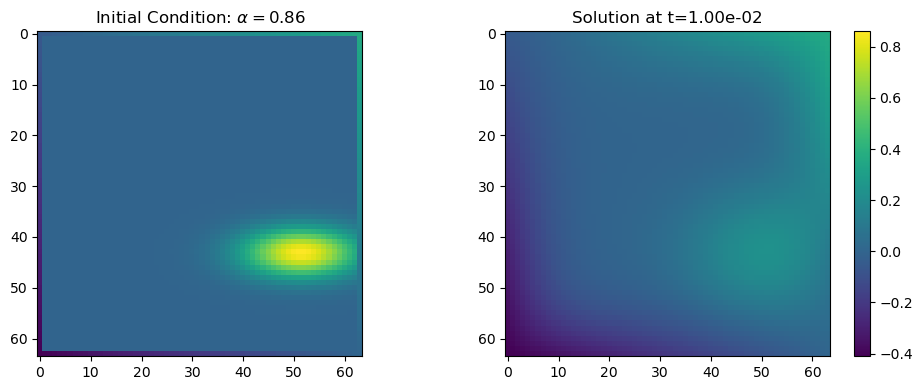

In [14]:
idx = 0     # which sample to visualize
t_idx = 2   # which time step to visualize

T = t_steps[t_idx].item()
alpha = data_labels[idx, 0].item()
A = data_A[idx, 0]  # (S, S)
U = data_U[idx, 0, :, :, t_idx]  # (S, S)

vmin, vmax = min(A.min(), U.min()), max(A.max(), U.max())
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
im0 = axs[0].imshow(A, cmap="viridis", vmin=vmin, vmax=vmax)
axs[0].set_title(f"Initial Condition: $\\alpha={alpha:.2f}$")
im1 = axs[1].imshow(U, cmap="viridis", vmin=vmin, vmax=vmax)
axs[1].set_title(f"Solution at t={T:.2e}")
fig.colorbar(im1, ax=axs[1])
plt.tight_layout()
plt.show()

In [15]:
sample_shape = cfg.dataset.sampling.sample_shape
generator = torch.Generator().manual_seed(0)

interior_a = 1.0
interior_u = 0.0
boundary_a = boundary_u = 0.5
same_boundary = True
boundary_obs_a = dpde.validation.random_boundary_mask(sample_shape[1], sample_shape[2], frac_obs=boundary_a)
if same_boundary:
    boundary_obs_u = boundary_obs_a[:]
else:
    boundary_obs_u = dpde.validation.random_boundary_mask(sample_shape[1], sample_shape[2], frac_obs=boundary_u)
interior_obs_a = dpde.validation.random_interior_mask(sample_shape[1], sample_shape[2], frac_obs=interior_a)
interior_obs_u = dpde.validation.random_interior_mask(sample_shape[1], sample_shape[2], frac_obs=interior_u)

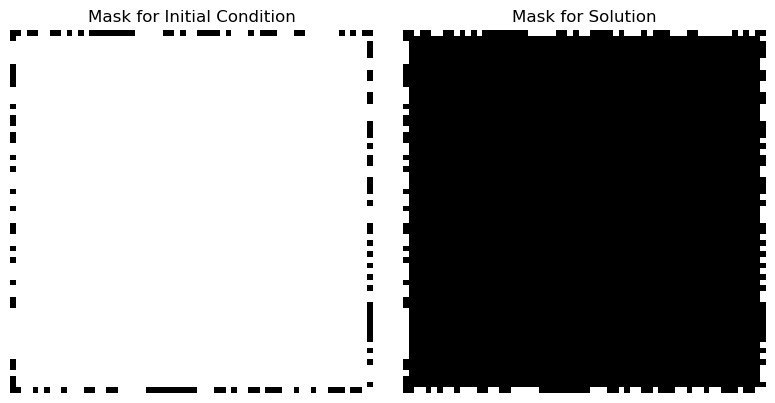

In [16]:
mask_a = dpde.validation.combine_masks(boundary_obs_a, interior_obs_a)
mask_u = dpde.validation.combine_masks(boundary_obs_u, interior_obs_u)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im0 = axs[0].imshow(mask_a.cpu(), cmap="gray", vmin=0, vmax=1)
axs[0].set_title("Mask for Initial Condition")
im1 = axs[1].imshow(mask_u.cpu(), cmap="gray", vmin=0, vmax=1)
axs[1].set_title("Mask for Solution")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [17]:
(2*64 + 2*64 -4) / ((64 - 2) * (64 - 2))

0.06555671175858481

In [32]:
obs_a = torch.tensor(A)
obs_u = torch.tensor(U)

dx = 1. / (A.shape[-1]-1)
ch_a = 1

sample_shape = (32, 2, 64, 64)

zeta_a = 50.0
zeta_u = 20.0
zeta_pde = 0.5

num_steps = 50

t_cond = torch.ones(sample_shape[0]) * T
alpha_cond = torch.ones_like(t_cond) * alpha
labels = torch.stack([t_cond, alpha_cond], dim=-1)

loss_fn_kwargs = {
    "obs_a": obs_a,
    "obs_u": obs_u,
    "mask_a": mask_a,
    "mask_u": mask_u,
    "dx": dx,
    "dy": dx,
    "ch_a": ch_a,
    "labels": alpha_cond,
}

torch.backends.cudnn.conv.fp32_precision = 'tf32'

#for i in range(10):
samples, losses = dpde.sampling.edm_sampler(
    net=edm,
    device=device,
    sample_shape=sample_shape,
    loss_fn=dpde.sampling.heat_loss,
    loss_fn_kwargs=loss_fn_kwargs,
    labels=labels,
    zeta_a=zeta_a,
    zeta_u=zeta_u,
    zeta_pde=zeta_pde,
    num_steps=num_steps,
    to_cpu=True,
    debug=True,
    return_losses=True,
    compile_net=False,
)
print(f"Final total loss: {losses[-1, 3]:.4f}")

Final total loss: 9.8948


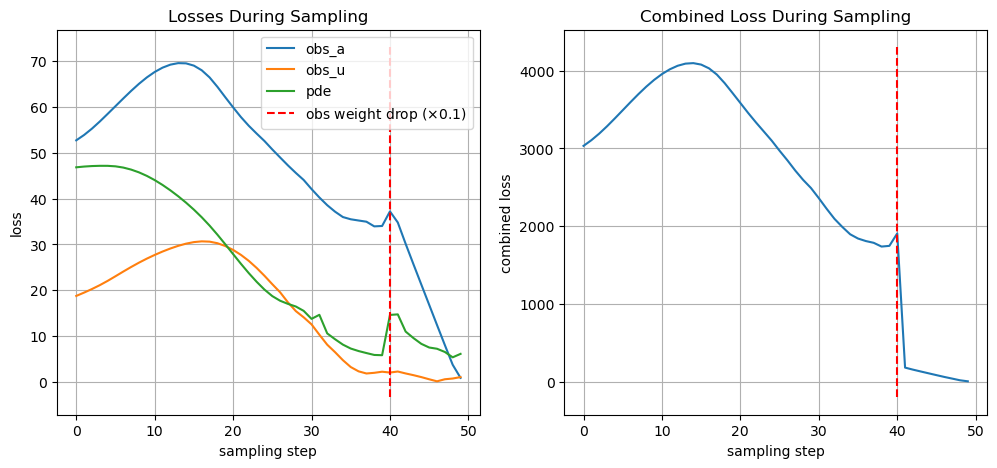

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses[:, :3])
axs[0].set(xlabel='sampling step', ylabel='loss', title="Losses During Sampling")
axs[0].grid()
axs[1].plot(losses[:, 3])
axs[1].set(xlabel='sampling step', ylabel='combined loss', title="Combined Loss During Sampling")
axs[1].grid()
for i in range(2):
    temp_min, temp_max = axs[i].get_ylim()
    axs[i].vlines(0.8 * num_steps, ymin=temp_min, ymax=temp_max, color='red', linestyle='--')
axs[0].legend(['obs_a', 'obs_u', 'pde', 'obs weight drop ($\\times 0.1$)'])
plt.show()

RMSE Initial Condition: 0.0108
RMSE Solution at t=0.010: 0.0382


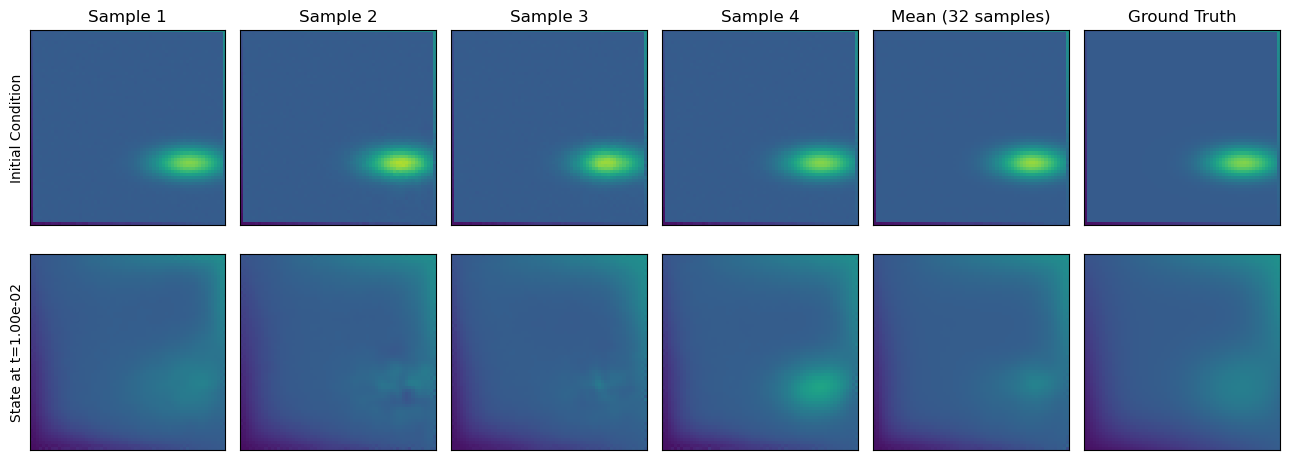

In [34]:
mean_val = samples.mean(axis=0)

vmin = min(samples[:].min(), obs_a.min(), obs_u.min())
vmax = max(samples[:].max(), obs_a.max(), obs_u.max())

print(f"RMSE Initial Condition: {torch.sqrt(torch.mean((samples[:, 0] - obs_a)**2)):.4f}")
print(f"RMSE Solution at t={T:.3f}: {torch.sqrt(torch.mean((samples[:, 1] - obs_u)**2)):.4f}")

fig, axs = plt.subplots(2, 6, figsize=(13, 5))
for i in range(4):
    axs[0, i].imshow(samples[i, 0], cmap='viridis', vmin=vmin, vmax=vmax)
    axs[0, i].set(aspect="equal", xticks=[], yticks=[])
    axs[0, i].set_title(f'Sample {i+1}')
    if i == 0:
        axs[0, i].set_ylabel('Initial Condition')
    axs[1, i].imshow(samples[i, 1], cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1, i].set(aspect="equal", xticks=[], yticks=[])
    if i == 0:
        axs[1, i].set_ylabel(f'State at t={T:.2e}')

axs[0, 4].imshow(mean_val[0], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 4].set(aspect="equal", xticks=[], yticks=[], title=f"Mean ({sample_shape[0]} samples)")
axs[1, 4].imshow(mean_val[1], cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 4].set(aspect="equal", xticks=[], yticks=[])

axs[0, 5].imshow(obs_a.numpy(), cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 5].set(aspect="equal", xticks=[], yticks=[], title="Ground Truth")
axs[1, 5].imshow(obs_u.numpy(), cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 5].set(aspect="equal", xticks=[], yticks=[])
plt.tight_layout()

In [35]:
N = 10
obs = torch.stack([obs_a, obs_u], dim=0)
errors = torch.zeros(N, t_steps.shape[0], sample_shape[0], sample_shape[1])
print("Errors shape:", errors.shape)
sq_error = (samples - obs.unsqueeze(0)) ** 2
print("Squared errors shape:", sq_error.shape)
msq_error = torch.mean(sq_error, dim=(2, 3))
print("Mean squared errors shape:", msq_error.shape)
errors[0] = torch.mean((samples - obs.unsqueeze(0)) ** 2, dim=(2, 3)).detach().cpu()

Errors shape: torch.Size([10, 101, 32, 2])
Squared errors shape: torch.Size([32, 2, 64, 64])
Mean squared errors shape: torch.Size([32, 2])


In [36]:
a_coeff = 1.0 / min(1, mask_a.sum())
u_coeff = 1.0 / min(1, mask_u.sum())
pde_coeff = 1.0

coeffs = np.array([a_coeff, u_coeff, pde_coeff])

def sampler_wrapper(params):
    zeta_a, zeta_u, zeta_pde = params
    samples, losses = dpde.sampling.edm_sampler(
        net=edm,
        device=device,
        sample_shape=sample_shape,
        loss_fn=dpde.sampling.heat_loss,
        loss_fn_kwargs=loss_fn_kwargs,
        labels=labels,
        zeta_a=zeta_a,
        zeta_u=zeta_u,
        zeta_pde=zeta_pde,
        num_steps=num_steps,
        to_cpu=True,
        debug=True,
        return_losses=True,
        compile_net=False,
    )

    return np.sum(np.dot(coeffs, losses[-1, :3]))

bounds = [
    (1.0, 100.0),   # bounds for zeta_a
    (1.0, 100.0),   # bounds for zeta_u
    (0.1, 10.0),    # bounds for zeta_pde
]

res = gp_minimize(
    sampler_wrapper,
    dimensions=bounds,
    n_calls=30,
    n_random_starts=5,
    acq_func="EI",
    random_state=0,
)   
print(f"Best parameters found: zeta_a={res.x[0]:.4f}, zeta_u={res.x[1]:.4f}, zeta_pde={res.x[2]:.4f}")

/home/s204790/miniconda3/envs/dyndiffenv2/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100.0, 1.0, 0.1] before, using random point [41.75819189307973, 5.615894501948737, 9.445228422253303]
  warnings.warn(
/home/s204790/miniconda3/envs/dyndiffenv2/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100.0, 1.0, 0.1] before, using random point [55.07899637860888, 59.4510184206347, 4.422883970042988]
  warnings.warn(
/home/s204790/miniconda3/envs/dyndiffenv2/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100.0, 1.0, 0.1] before, using random point [38.15282656321439, 12.330171191386128, 8.758217569917104]
  warnings.warn(
/home/s204790/miniconda3/envs/dyndiffenv2/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point 

Best parameters found: zeta_a=100.0000, zeta_u=14.5742, zeta_pde=0.5118
